# Compare Caffe vs. PyTorch

In [1]:
import sys
# sys.path.insert(0, "/home/ruthfong/caffe-1.0")
sys.path.insert(0, "/home/ruthfong/deepcontext/caffe_ext")

import caffe
print(caffe)

<module 'caffe' from '/users/ruthfong/caffe-1.0/python/caffe/__init__.pyc'>


In [2]:
from PIL import Image

import models.caffe_utils as cutils
from models.self_supervised import alexnet, PUZZLE
from models.self_supervised_caffe import get_caffe_model, DEFAULT_IMG_PATH
from models.transforms import get_transform

In [3]:
task_name = "weakly_deepcontext"

disable_ceil_mode = False

img_path = DEFAULT_IMG_PATH

caffe_net = get_caffe_model(task_name)
caffe_net, caffe_res = cutils.net_forward(caffe_net, img_path)

torch_net = alexnet(task_name, pretrained=True)

if disable_ceil_mode:
    for m in torch_net.modules():
        if hasattr(m, "ceil_mode"):
            m.ceil_mode = True

img = Image.open(img_path).convert('RGB')
transform = get_transform(task_name, 227)
x = transform(img).unsqueeze(0)
y = torch_net(x)

/users/ruthfong/anaconda3/envs/caffe_py27/lib/python2.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')
/users/ruthfong/anaconda3/envs/caffe_py27/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/users/ruthfong/anaconda3/envs/caffe_py27/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


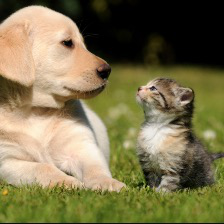

In [4]:
isinstanceimg

In [4]:
transform

Compose(
    ToTensor()
)

In [4]:
(caffe_res['pool5'] - y.cpu().data.numpy()).max()

5.185604e-06

# Deep Context -- Check with Caffe

In [46]:
import random
import math
import caffe
import numpy as np
from scipy import misc

def prep_image(im):
    # for some patches, randomly downsample to as little as 100 total pixels
    if(False and random.random() < .33):
        origsz=im.shape
        randpix=int(math.sqrt(random.random() * (95 * 95 - 10 * 10) + 10 * 10))
        im=caffe.io.resize(im.astype(np.uint8), (randpix, randpix))
        im=(caffe.io.resize(im, (origsz[0], origsz[1])) * 255).astype(np.float32)

    # randomly drop all but one color channel
    chantokeep=random.randint(0, 2);
    mean=[123, 117, 104]
    for i in range(0, 3):
        if True or i==chantokeep:
            print(i)
            im[:,:,i]-=np.mean(im[:,:,i])
        else:
            im[:,:,i]=np.random.uniform(0, 1, (im.shape[0], im.shape[1])) - .5

    # Normalize the mean and variance so that gradients are a less useful cue;
    # then scale by 50 so that the variance is roughly the same as the usual
    # AlexNet inputs.
    im=im / np.sqrt(np.mean(np.square(im))) * 50
    return im.transpose(2, 0, 1)

In [47]:
im = misc.imread(DEFAULT_IMG_PATH)
x2 = prep_image(im.astype(float))

0
1
2


/home/ruthfong/anaconda3/envs/caffe_py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [48]:
from models.transforms import *
# from torchvision import transforms

transform = transforms.Compose([
    CaffeScale(scale=1.),
    #CaffeResize(224),
    transforms.ToTensor(),
    CaffeChannelNormalize(),
    CaffeDeepContextNormalize(),
    # CaffeChannelSwap(), # TODO(ruthfong): Change saved model to remove this.
])

img = Image.open(DEFAULT_IMG_PATH).convert('RGB')
x = transform(img)

In [49]:
(x.cpu().data.numpy() - x2).max()

2.842170943040401e-14

In [42]:
x2

array([[[-1.06074358e+02, -1.08074358e+02, -1.13074358e+02, ...,
         -1.25074358e+02, -1.25074358e+02, -1.25074358e+02],
        [-1.04074358e+02, -1.07074358e+02, -1.10074358e+02, ...,
         -1.25074358e+02, -1.25074358e+02, -1.25074358e+02],
        [-1.02074358e+02, -1.04074358e+02, -1.07074358e+02, ...,
         -1.25074358e+02, -1.25074358e+02, -1.25074358e+02],
        ...,
        [-3.30743583e+01, -2.60743583e+01, -1.50743583e+01, ...,
         -4.50743583e+01, -4.30743583e+01, -4.50743583e+01],
        [-3.70743583e+01, -3.10743583e+01, -2.10743583e+01, ...,
         -4.50743583e+01, -4.30743583e+01, -4.50743583e+01],
        [-1.19074358e+02, -1.18074358e+02, -1.14074358e+02, ...,
         -1.16074358e+02, -1.14074358e+02, -1.16074358e+02]],

       [[-8.50701929e+01, -8.90701929e+01, -9.40701929e+01, ...,
         -1.16070193e+02, -1.16070193e+02, -1.16070193e+02],
        [-8.50701929e+01, -8.80701929e+01, -9.30701929e+01, ...,
         -1.16070193e+02, -1.16070193e

In [21]:
x2

array([[[ 4.51338149e-01, -3.26747322e-01, -4.51113179e-02, ...,
         -4.28251151e-01,  3.23755341e-01, -2.24513551e-01],
        [ 4.13270816e-01,  7.23479068e-03,  2.06189953e-01, ...,
          4.53633551e-01,  1.16637493e-01,  2.44966716e-01],
        [-2.01988110e-01,  1.85494169e-01, -4.62819461e-01, ...,
          9.62799448e-02, -7.81510615e-02, -4.44735618e-01],
        ...,
        [ 2.55049120e-01, -4.64914461e-01, -2.76354379e-01, ...,
         -7.39079598e-02, -1.58925093e-01,  2.27669233e-01],
        [-1.84945284e-01, -2.05270158e-01, -4.75252047e-01, ...,
         -4.32784127e-01, -6.83629070e-03,  2.05007600e-01],
        [ 3.76010044e-01,  1.91940826e-01, -3.02965318e-01, ...,
         -3.65002205e-01,  4.32635210e-01,  3.86825646e-01]],

       [[ 2.35749650e-01, -4.46212081e-01,  3.62949743e-01, ...,
         -3.67144676e-01,  3.21177291e-02,  2.25328535e-01],
        [-2.59901085e-01, -2.42540170e-01,  2.19684677e-01, ...,
         -3.01950621e-01,  3.34001416e

In [22]:
x

tensor([[[-1.0607e+02, -1.0807e+02, -1.1307e+02,  ..., -1.2507e+02,
          -1.2507e+02, -1.2507e+02],
         [-1.0407e+02, -1.0707e+02, -1.1007e+02,  ..., -1.2507e+02,
          -1.2507e+02, -1.2507e+02],
         [-1.0207e+02, -1.0407e+02, -1.0707e+02,  ..., -1.2507e+02,
          -1.2507e+02, -1.2507e+02],
         ...,
         [-3.3074e+01, -2.6074e+01, -1.5074e+01,  ..., -4.5074e+01,
          -4.3074e+01, -4.5074e+01],
         [-3.7074e+01, -3.1074e+01, -2.1074e+01,  ..., -4.5074e+01,
          -4.3074e+01, -4.5074e+01],
         [-1.1907e+02, -1.1807e+02, -1.1407e+02,  ..., -1.1607e+02,
          -1.1407e+02, -1.1607e+02]],

        [[-8.5070e+01, -8.9070e+01, -9.4070e+01,  ..., -1.1607e+02,
          -1.1607e+02, -1.1607e+02],
         [-8.5070e+01, -8.8070e+01, -9.3070e+01,  ..., -1.1607e+02,
          -1.1607e+02, -1.1607e+02],
         [-8.5070e+01, -8.7070e+01, -9.2070e+01,  ..., -1.1607e+02,
          -1.1607e+02, -1.1607e+02],
         ...,
         [-7.0702e+00, -7

In [52]:
import torch
x = torch.randn(3, 224, 224)

In [61]:
x = x - x.mean(dim=[1,2]).unsqueeze(1).unsqueeze(2)

(array([ 12434.,  10554.,   6370., 102795.,   1957.,   3017.,   4710.,
          5201.,   2918.,    572.]),
 array([-100.28412355,  -70.24377626,  -40.20342898,  -10.16308169,
          19.87726559,   49.91761287,   79.95796016,  109.99830744,
         140.03865473,  170.07900201,  200.1193493 ]),
 <a list of 10 Patch objects>)

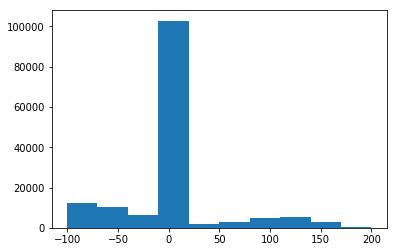

In [46]:
plt.hist(x.reshape(-1))

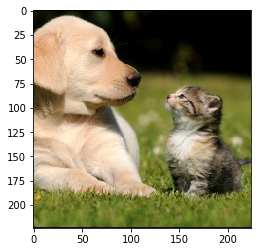

In [20]:
import matplotlib.pyplot as plt
plt.imshow(im) #x.transpose(1, 2, 0))
plt.show()

# Replicating Object-Centric Model

In [18]:
import torch
import torch.nn as nn
import numpy as np

In [4]:
caffe_net = get_caffe_model(task_name='weakly_objectcentric')
caffe_net, caffe_res = cutils.net_forward(caffe_net, img_path)

In [6]:
caffe_net.blobs

OrderedDict([('data', <caffe._caffe.Blob at 0x7fa989e3a6e0>),
             ('conv1', <caffe._caffe.Blob at 0x7fa989e3a9b0>),
             ('pool1', <caffe._caffe.Blob at 0x7fa989e3ab18>),
             ('norm1', <caffe._caffe.Blob at 0x7fa989e3a7d0>),
             ('conv2', <caffe._caffe.Blob at 0x7fa989e3a938>),
             ('pool2', <caffe._caffe.Blob at 0x7fa989e3a668>),
             ('norm2', <caffe._caffe.Blob at 0x7fa989e3a848>),
             ('conv3', <caffe._caffe.Blob at 0x7fa989e3a8c0>),
             ('conv4', <caffe._caffe.Blob at 0x7fa989e3aaa0>),
             ('conv5', <caffe._caffe.Blob at 0x7fa989e3aa28>),
             ('pool5', <caffe._caffe.Blob at 0x7fa989e3a500>),
             ('fc6', <caffe._caffe.Blob at 0x7fa989e3a398>),
             ('fc7', <caffe._caffe.Blob at 0x7fa989e3a320>)])

In [13]:
print(caffe_net.blobs['pool5'].data.shape)
print(caffe_net.blobs['fc6'].data.shape)

(1, 256, 6, 6)
(1, 4096)


In [16]:
np.prod(caffe_net.blobs['pool5'].data.shape)

9216

In [34]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(*[
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            ])

    def forward(self, x):
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [35]:
model = Model()
params = caffe_net.params
model.classifier[0].weight.data[...] = torch.from_numpy(params['fc6'][0].data)
model.classifier[0].bias.data[...] = torch.from_numpy(params['fc6'][1].data)
model.classifier[2].weight.data[...] = torch.from_numpy(params['fc7'][0].data)
model.classifier[2].bias.data[...] = torch.from_numpy(params['fc7'][1].data)

In [36]:
x = torch.from_numpy(caffe_net.blobs['pool5'].data)
(model(x).cpu().data.numpy() - caffe_net.blobs['fc7'].data).max()

0.0

# Debug Audio Model

In [37]:
caffe_net = get_caffe_model(task_name='weakly_audio')
caffe_net, caffe_res = cutils.net_forward(caffe_net, img_path)

In [39]:
caffe_net.blobs['conv1'].data.shape

(1, 96, 55, 55)

In [46]:
caffe_net.params

OrderedDict([('conv1', <caffe._caffe.BlobVec at 0x7fa9866dcd70>),
             ('bn1', <caffe._caffe.BlobVec at 0x7fa986687360>),
             ('conv2', <caffe._caffe.BlobVec at 0x7fa9866873d0>),
             ('bn2', <caffe._caffe.BlobVec at 0x7fa9866872f0>),
             ('conv3', <caffe._caffe.BlobVec at 0x7fa986687440>),
             ('bn3', <caffe._caffe.BlobVec at 0x7fa9866874b0>),
             ('conv4', <caffe._caffe.BlobVec at 0x7fa986687520>),
             ('bn4', <caffe._caffe.BlobVec at 0x7fa986687590>),
             ('conv5', <caffe._caffe.BlobVec at 0x7fa986687600>),
             ('bn5', <caffe._caffe.BlobVec at 0x7fa986687670>)])

In [65]:
hasattr(model[0], 'running_mean')

True

In [64]:
model = nn.Sequential(*[
    nn.BatchNorm2d(96, eps=1e-5, momentum=.999, track_running_stats=True, affine=False),
    nn.ReLU(inplace=True),
])
params = caffe_net.params
model[0].running_mean.data[...] = torch.from_numpy(params['bn1'][0].data) / params['bn1'][2].data[0]
model[0].running_var.data[...] = torch.from_numpy(params['bn1'][1].data) / params['bn1'][2].data[0]
# model.eval()

In [61]:
x = torch.from_numpy(caffe_net.blobs['conv1'].data)
(model(x).cpu().data.numpy() - caffe_net.blobs['bn1'].data).max()

9.536743e-07

# Debug Caffe vs. PyTorch Transformation Difference

In [199]:
import os
import caffe
from caffe.io import resize_image

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from torchvision import datasets, models, transforms

from models.self_supervised import PUZZLE
from models.self_supervised_caffe import convert_caffe_to_pytorch, DEFAULT_IMG_PATH, DEFAULT_CAFFE_MODELS_DIR
from models.caffe_utils import get_imagenet_mean, get_caffe_model

In [252]:
size = (227, 227)
def resize(x):
    if not isinstance(size, int):
        orig_height, orig_width = size
    else:
        height, width = x.shape[1:3]
        if width < height:
            orig_width = size
            orig_height = int(size * height / width)
        else:
            orig_height = size
            orig_width = int(size * width / height)
    with torch.no_grad():
        x = F.interpolate(x.unsqueeze(0), (orig_height, orig_width),
                          mode='bilinear', align_corners=False)
        x = x.squeeze(0)
    return x

In [259]:
def resize_image(im, new_dims, interp_order=1):
    """
    Resize an image array with interpolation.
    Parameters
    ----------
    im : (H x W x K) ndarray
    new_dims : (height, width) tuple of new dimensions.
    interp_order : interpolation order, default is linear.
    Returns
    -------
    im : resized ndarray with shape (new_dims[0], new_dims[1], K)
    """
    from skimage.transform import resize

    if im.shape[-1] == 1 or im.shape[-1] == 3:
        im_min, im_max = im.min(), im.max()
        if im_max > im_min:
            # skimage is fast but only understands {1,3} channel images
            # in [0, 1].
            im_std = (im - im_min) / (im_max - im_min)
            resized_std = resize(im_std, new_dims, order=interp_order, mode='constant')
            resized_im = resized_std * (im_max - im_min) + im_min
        else:
            # the image is a constant -- avoid divide by 0
            ret = np.empty((new_dims[0], new_dims[1], im.shape[-1]),
                           dtype=np.float32)
            ret.fill(im_min)
            return ret
    else:
        # ndimage interpolates anything but more slowly.
        scale = tuple(np.array(new_dims, dtype=float) / np.array(im.shape[:2]))
        resized_im = zoom(im, scale + (1,), order=interp_order)
    return resized_im.astype(np.float32)

In [260]:
caffe_models_dir = DEFAULT_CAFFE_MODELS_DIR
task_name = PUZZLE
prototxt_path = os.path.join(caffe_models_dir,
                             task_name + '.prototxt')
caffemodel_path = os.path.join(caffe_models_dir,
                               task_name + '.caffemodel')
net = get_caffe_model(prototxt_path, caffemodel_path)

In [295]:
mu

array([104.00698793, 116.66876762, 122.67891434])

In [290]:
transformer = caffe.io.Transformer({'data':net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
mu = get_imagenet_mean()
transformer.set_mean('data', mu)
transformer.set_raw_scale('data', 255)
# transformer.set_channel_swap('data', (2,1,0))

bgr_mean = mu # [103.939, 116.779, 123.68]
mean = [m / 255. for m in bgr_mean]
# mean = [m / 255. for m in reversed(bgr_mean)]
std = [1 / 255.] * 3

transform = transforms.Compose([
    lambda x: np.array(x) / 255.,
    lambda x: resize_image(x, (227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    # resize,
])

In [291]:
caffe_in = img.astype(np.float32, copy=False)
in_dims = transformer.inputs['data'][2:]
if caffe_in.shape[:2] != in_dims:
    print('here')
    caffe_in = resize_image(caffe_in, in_dims)

here


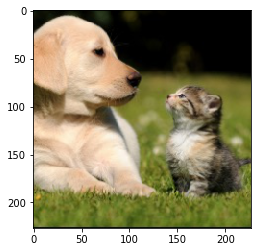

In [292]:
f, ax = plt.subplots(1, 1)
ax.imshow(caffe_in)
plt.show()

In [293]:
img_paths = DEFAULT_IMG_PATH

net.blobs['data'].reshape(1,
                          3,
                          net.blobs['data'].data.shape[2],
                          net.blobs['data'].data.shape[3])

img = caffe.io.load_image(img_paths)
net.blobs['data'].data[...] = transformer.preprocess('data', img)
x_caffe = net.blobs['data'].data

img_ = Image.open(img_paths).convert('RGB')
x = transform(img_).unsqueeze(0)

In [294]:
max_diff = np.abs(x_caffe - x.cpu().data.numpy()).max()
mag = max(np.abs(x_caffe).max(), np.abs(x.cpu().data.numpy()).max())
max_diff / mag

2.0211252e-07

In [289]:
x

tensor([[[[ -85.2572,  -87.0799,  -91.9222,  ..., -104.0070, -104.0070,
           -104.0070],
          [ -83.1851,  -85.9677,  -88.9660,  ..., -104.0070, -104.0070,
           -104.0070],
          [ -81.2246,  -83.0658,  -86.0070,  ..., -104.0070, -104.0070,
           -104.0070],
          ...,
          [ -12.7462,   -5.3103,    5.4324,  ...,  -23.9409,  -22.0466,
            -24.5356],
          [ -18.2033,  -11.8486,   -2.1771,  ...,  -25.3484,  -23.4541,
            -25.9338],
          [ -98.0860,  -97.0729,  -93.2110,  ...,  -95.0008,  -93.1190,
            -95.1255]],

         [[ -86.0771,  -89.7684,  -94.6500,  ..., -116.6688, -116.6688,
           -116.6688],
          [ -85.8736,  -88.6287,  -93.5234,  ..., -116.6688, -116.6688,
           -116.6688],
          [ -85.8736,  -87.6615,  -92.5366,  ..., -116.6688, -116.6688,
           -116.6688],
          ...,
          [  -8.5860,   -1.0382,    6.8356,  ...,  -19.8009,  -19.8406,
            -22.4278],
          [ -15.96

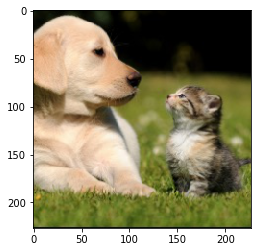

In [190]:
f, ax = plt.subplots(1, 1)
ax.imshow(np.transpose(x_caffe[0], (1, 2, 0)))
plt.show()

In [186]:
x_caffe - x.data.numpy()

ValueError: operands could not be broadcast together with shapes (1,3,227,227) (1,3,224,224) 

(224, 224, 3)

In [2]:
net = convert_caffe_to_pytorch(gpu=0)

/users/ruthfong/anaconda3/envs/caffe_py27/lib/python2.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')
/users/ruthfong/anaconda3/envs/caffe_py27/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/users/ruthfong/anaconda3/envs/caffe_py27/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


> /home/ruthfong/pytorch_models/models/self_supervised_caffe.py(26)convert_caffe_to_pytorch()
-> return net
(Pdb) c


In [13]:
import os

from caffe.proto import caffe_pb2
import google.protobuf.text_format as txtf

import torch
import torch.nn as nn

from models.self_supervised_caffe import DEFAULT_CAFFE_MODELS_DIR
from models.self_supervised import PUZZLE

task_name = PUZZLE
prototxt_path = os.path.join(DEFAULT_CAFFE_MODELS_DIR, task_name + '.prototxt')

net_p = caffe_pb2.NetParameter()

with open(prototxt_path) as f:
    s = f.read()
    txtf.Merge(s, net_p)

layer_names = [l.name for l in net_p.layer]

In [5]:
layer_names

[u'conv1_s1',
 u'relu1_s1',
 u'pool1_s1',
 u'norm1_s1',
 u'conv2_s1',
 u'relu2_s1',
 u'pool2_s1',
 u'norm2_s1',
 u'conv3_s1',
 u'relu3_s1',
 u'conv4_s1',
 u'relu4_s1',
 u'conv5_s1',
 u'relu5_s1',
 u'pool5']

In [83]:
net_p.layer[3]

name: "norm1_s1"
type: "LRN"
bottom: "pool1_s1"
top: "norm1_s1"
lrn_param {
  local_size: 5
  alpha: 9.99999974738e-05
  beta: 0.75
}

In [105]:
new_model = nn.Sequential(*[
    nn.Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4)),
nn.ReLU(inplace=True),
nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True),
nn.LocalResponseNorm(5, alpha=9.99999974738e-05, beta=0.75, k=1.0),
nn.Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2),
nn.ReLU(inplace=True),
nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True),
nn.LocalResponseNorm(5, alpha=9.99999974738e-05, beta=0.75, k=1.0),
nn.Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
nn.ReLU(inplace=True),
nn.Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2),
nn.ReLU(inplace=True),
nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2),
nn.ReLU(inplace=True),
nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True),
])

In [114]:
'torch.nn' in str(type(m))

True

In [118]:
assert isinstance(features, nn.Sequential)
str_rep = 'Sequential(*[\n'
for m in features:
    prefix = 'nn.' if 'torch.nn' in repr(type(m)) else ''
    str_rep += prefix + str(m) + ',\n'
str_rep += '])'
print(str_rep)

Sequential(*[
nn.Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4)),
nn.ReLU(inplace=True),
nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True),
nn.LocalResponseNorm(5, alpha=9.99999974738e-05, beta=0.75, k=1.0),
nn.Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2),
nn.ReLU(inplace=True),
nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True),
nn.LocalResponseNorm(5, alpha=9.99999974738e-05, beta=0.75, k=1.0),
nn.Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
nn.ReLU(inplace=True),
nn.Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2),
nn.ReLU(inplace=True),
nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2),
nn.ReLU(inplace=True),
nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True),
])


In [127]:
net_p.layer[1].top

[u'conv1_s1']

In [129]:
POOL_MAX = 0;
POOL_AVE = 1;
POOL_STOCHASTIC = 2;

def extract_param(param, default_value=None):
    if isinstance(param, int) or isinstance(param, float):
        return param
    if len(param) == 1:
        return int(param[0])
    elif len(param) == 0:
        if default_value is not None:
            return default_value
        else:
            # TODO(ruthfong): raise specific error.
            assert False
    else:
        raise NotImplementedError

get_stride = lambda p: extract_param(p.stride, 1)
get_padding = lambda p: extract_param(p.pad, 0)
get_kernel_size = lambda p: extract_param(p.kernel_size)
get_bias = lambda p: extract_param(p.bias_term, True)
get_groups = lambda p: extract_param(p.group, 1)
get_local_size = lambda p: extract_param(p.local_size, 5)
get_alpha = lambda p: extract_param(p.alpha, 1.)
get_beta = lambda p: extract_param(p.beta, 0.75)
get_k = lambda p: extract_param(p.k, 1.)

prev_dim = 3
inplace = True
new_layers = []
learnable_layers = {}

for i, layer in enumerate(net_p.layer):
    if layer.type == 'Convolution':
        p = layer.convolution_param
        kernel_size = get_kernel_size(p)
        stride = get_stride(p)
        padding = get_padding(p)
        bias = get_bias(p)
        groups = get_groups(p)
        new_layer = nn.Conv2d(prev_dim,
                              p.num_output,
                              kernel_size,
                              stride=stride,
                              padding=padding,
                              dilation=1,
                              groups=groups,
                              bias=bias,
                              padding_mode='zeros')
        assert len(layer.top) == 1
        learnable_layers[layer.top[0]] = i
        prev_dim = p.num_output
    elif layer.type == 'ReLU':
        assert len(layer.top) == 1
        assert len(layer.bottom) == 1
        new_layer = nn.ReLU(inplace=inplace if inplace else layer.top[0] == layer.bottom[0])
    elif layer.type == 'Pooling':
        p = layer.pooling_param
        kernel_size = get_kernel_size(p)
        stride = get_stride(p)
        padding = get_padding(p)
        ceil_mode = True  # caffe uses ceil_mode=True
        if p.pool is POOL_MAX:
            new_layer = nn.MaxPool2d(kernel_size,
                                     stride=stride,
                                     padding=padding,
                                     dilation=1,
                                     return_indices=False,
                                     ceil_mode=ceil_mode)
        else:
            raise NotImplementedError
    elif layer.type == 'LRN':
        p = layer.lrn_param
        local_size = get_local_size(p)
        alpha = get_alpha(p)
        beta = get_beta(p)
        k = get_k(p)
        new_layer = nn.LocalResponseNorm(local_size,
                                         alpha=alpha,
                                         beta=beta,
                                         k=k)
    else:
        raise NotImplementedError
    print(i, layer)#, new_layer)
    new_layers.append(new_layer)

(0, name: "conv1_s1"
type: "Convolution"
bottom: "data"
top: "conv1_s1"
convolution_param {
  num_output: 96
  kernel_size: 11
  stride: 4
}
)
(1, name: "relu1_s1"
type: "ReLU"
bottom: "conv1_s1"
top: "conv1_s1"
)
(2, name: "pool1_s1"
type: "Pooling"
bottom: "conv1_s1"
top: "pool1_s1"
pooling_param {
  pool: MAX
  kernel_size: 3
  stride: 2
}
)
(3, name: "norm1_s1"
type: "LRN"
bottom: "pool1_s1"
top: "norm1_s1"
lrn_param {
  local_size: 5
  alpha: 9.99999974738e-05
  beta: 0.75
}
)
(4, name: "conv2_s1"
type: "Convolution"
bottom: "norm1_s1"
top: "conv2_s1"
convolution_param {
  num_output: 256
  pad: 2
  kernel_size: 5
  group: 2
}
)
(5, name: "relu2_s1"
type: "ReLU"
bottom: "conv2_s1"
top: "conv2_s1"
)
(6, name: "pool2_s1"
type: "Pooling"
bottom: "conv2_s1"
top: "pool2_s1"
pooling_param {
  pool: MAX
  kernel_size: 3
  stride: 2
}
)
(7, name: "norm2_s1"
type: "LRN"
bottom: "pool2_s1"
top: "norm2_s1"
lrn_param {
  local_size: 5
  alpha: 9.99999974738e-05
  beta: 0.75
}
)
(8, name: "con

In [135]:
features = nn.Sequential(*new_layers)
for param_name, param in net.params.items():
    layer_i = learnable_layers[param_name]
    num_params = len(param)
    assert num_params > 0
    assert num_params < 3
    assert 'conv' in param_name
    features[layer_i].weight.data[...] = torch.from_numpy(param[0].data)
    if num_params == 2:
        features[layer_i].bias.data[...] = torch.from_numpy(param[1].data)

In [21]:
model = models.alexnet()

In [176]:
from torchvision.models.utils import load_state_dict_from_url

model_urls = {
    'weakly_solvingpuzzle': 'https://github.com/ruthcfong/pytorch_models/releases/download/v2.0/alexnet-weakly_solvingpuzzle-7e75c18e.pt',
}

class AlexNetPuzzle(nn.Module):
    def __init__(self, params=None):
        super(AlexNetPuzzle, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75),
            nn.Conv2d(96, 256, kernel_size=5, groups=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, groups=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, groups=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        if params:
            self.load_caffe_weights(params)

    def forward(self, x):
        return self.features(x)

    def load_caffe_weights(self, params):
        self.features[0].weight.data[...] = torch.from_numpy(params['conv1_s1'][0].data)
        self.features[0].bias.data[...] = torch.from_numpy(params['conv1_s1'][1].data)
        self.features[4].weight.data[...] = torch.from_numpy(params['conv2_s1'][0].data)
        self.features[4].bias.data[...] = torch.from_numpy(params['conv2_s1'][1].data)
        self.features[8].weight.data[...] = torch.from_numpy(params['conv3_s1'][0].data)
        self.features[8].bias.data[...] = torch.from_numpy(params['conv3_s1'][1].data)
        self.features[10].weight.data[...] = torch.from_numpy(params['conv4_s1'][0].data)
        self.features[10].bias.data[...] = torch.from_numpy(params['conv4_s1'][1].data)
        self.features[12].weight.data[...] = torch.from_numpy(params['conv5_s1'][0].data)
        self.features[12].bias.data[...] = torch.from_numpy(params['conv5_s1'][1].data)

def alexnet(task_name='weakly_solvingpuzzle',
            pretrained=False,
            progress=True,
            **kwargs):
    assert task_name == 'weakly_solvingpuzzle'
    if task_name == 'weakly_solvingpuzzle':
        AlexNetPuzzle(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[task_name],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [177]:
model = alexnet(pretrained=True)

Downloading: "https://github.com/ruthcfong/pytorch_models/releases/download/v2.0/alexnet-weakly_solvingpuzzle-7e75c18e.pt" to /users/ruthfong/.cache/torch/checkpoints/alexnet-weakly_solvingpuzzle-7e75c18e.pt
100.0%


In [158]:
new_model = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75),
    nn.Conv2d(96, 256, kernel_size=5, groups=2, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75),
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(384, 384, kernel_size=3, groups=2, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(384, 256, kernel_size=3, groups=2, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2)
)

In [170]:
model = AlexNetPuzzle(params=net.params)

In [173]:
pytorch_models_dir = '/scratch/local/ssd/ruthfong/models/net_dissect/pytorch'
torch.save(model.state_dict(), os.path.join(pytorch_models_dir, caffe_model_name + '.pt'))

In [159]:
new_model[0].weight.data[...] = torch.from_numpy(net.params['conv1_s1'][0].data)
new_model[0].bias.data[...] = torch.from_numpy(net.params['conv1_s1'][1].data)
new_model[4].weight.data[...] = torch.from_numpy(net.params['conv2_s1'][0].data)
new_model[4].bias.data[...] = torch.from_numpy(net.params['conv2_s1'][1].data)
new_model[8].weight.data[...] = torch.from_numpy(net.params['conv3_s1'][0].data)
new_model[8].bias.data[...] = torch.from_numpy(net.params['conv3_s1'][1].data)
new_model[10].weight.data[...] = torch.from_numpy(net.params['conv4_s1'][0].data)
new_model[10].bias.data[...] = torch.from_numpy(net.params['conv4_s1'][1].data)
new_model[12].weight.data[...] = torch.from_numpy(net.params['conv5_s1'][0].data)
new_model[12].bias.data[...] = torch.from_numpy(net.params['conv5_s1'][1].data)

In [136]:
x = torch.from_numpy(net.blobs['data'].data)

In [138]:
(features(x).cpu().data.numpy() - net.blobs['pool5'].data).max()

1.23381615e-05

In [101]:
net.blobs['norm1_s1'].data.shape

(1, 96, 27, 27)

In [127]:
new_model(x).cpu().data.numpy().shape

(1, 256, 23, 23)

In [140]:
res = net.forward()

In [145]:
res.values()

[array([[[[0.        , 0.        , 0.        , 0.85551125, 1.3025935 ,
           1.3025935 ],
          [3.3760371 , 1.4088893 , 0.366484  , 0.        , 0.        ,
           0.        ],
          [4.459055  , 2.8510556 , 1.6761396 , 0.        , 0.        ,
           0.        ],
          [4.459055  , 2.8510556 , 1.0216339 , 0.        , 0.        ,
           0.        ],
          [3.5553567 , 0.        , 0.        , 0.        , 0.        ,
           0.2769971 ],
          [7.378141  , 0.5810433 , 0.72360927, 0.96689403, 1.3337975 ,
           5.6620555 ]],
 
         [[3.3095646 , 2.8439968 , 1.460573  , 0.        , 1.6661899 ,
           4.248808  ],
          [1.3726615 , 1.0828011 , 0.53819937, 3.356305  , 1.675411  ,
           8.006325  ],
          [1.7812512 , 1.7812512 , 1.279727  , 3.356305  , 1.6539552 ,
           7.875453  ],
          [1.8288398 , 1.391819  , 1.279727  , 2.2421281 , 0.        ,
           4.818714  ],
          [1.5117986 , 0.08267725, 0.85451657, 

In [144]:
res

{'pool5': array([[[[0.        , 0.        , 0.        , 0.85551125, 1.3025935 ,
           1.3025935 ],
          [3.3760371 , 1.4088893 , 0.366484  , 0.        , 0.        ,
           0.        ],
          [4.459055  , 2.8510556 , 1.6761396 , 0.        , 0.        ,
           0.        ],
          [4.459055  , 2.8510556 , 1.0216339 , 0.        , 0.        ,
           0.        ],
          [3.5553567 , 0.        , 0.        , 0.        , 0.        ,
           0.2769971 ],
          [7.378141  , 0.5810433 , 0.72360927, 0.96689403, 1.3337975 ,
           5.6620555 ]],
 
         [[3.3095646 , 2.8439968 , 1.460573  , 0.        , 1.6661899 ,
           4.248808  ],
          [1.3726615 , 1.0828011 , 0.53819937, 3.356305  , 1.675411  ,
           8.006325  ],
          [1.7812512 , 1.7812512 , 1.279727  , 3.356305  , 1.6539552 ,
           7.875453  ],
          [1.8288398 , 1.391819  , 1.279727  , 2.2421281 , 0.        ,
           4.818714  ],
          [1.5117986 , 0.08267725, 0.8